In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=False)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16
learning_rate = 0.0001

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion4ver/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion4ver/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


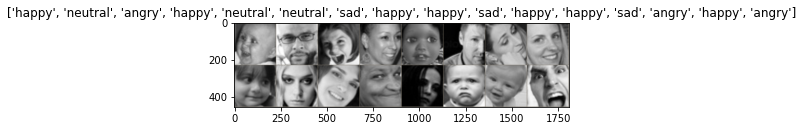

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.0001_adam_batch16_epoch20_pretrainFalse.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/20], Step [0/1313], Loss: 7.1582
Epoch [1/20], Step [20/1313], Loss: 1.5041
Epoch [1/20], Step [40/1313], Loss: 1.2604
Epoch [1/20], Step [60/1313], Loss: 1.5979
Epoch [1/20], Step [80/1313], Loss: 1.3055
Epoch [1/20], Step [100/1313], Loss: 1.3373
Epoch [1/20], Step [120/1313], Loss: 1.6141
Epoch [1/20], Step [140/1313], Loss: 1.3295
Epoch [1/20], Step [160/1313], Loss: 1.3325
Epoch [1/20], Step [180/1313], Loss: 1.4051
Epoch [1/20], Step [200/1313], Loss: 1.3994
Epoch [1/20], Step [220/1313], Loss: 1.4623
Epoch [1/20], Step [240/1313], Loss: 1.4247
Epoch [1/20], Step [260/1313], Loss: 1.3748
Epoch [1/20], Step [280/1313], Loss: 1.2582
Epoch [1/20], Step [300/1313], Loss: 1.2591
Epoch [1/20], Step [320/1313], Loss: 1.4325
Epoch [1/20], Step [340/1313], Loss: 1.4768
Epoch [1/20], Step [360/1313], Loss: 1.1843
Epoch [1/20], Step [380/1313], Loss: 1.2967
Epoch [1/20], Step [400/1313], Loss: 1.1564
Epoch [1/20], Step [420/1313], Loss: 1.3653
Epoch [1/20], Step [440/1313]

Epoch [3/20], Step [960/1313], Loss: 1.1629
Epoch [3/20], Step [980/1313], Loss: 0.7209
Epoch [3/20], Step [1000/1313], Loss: 0.7497
Epoch [3/20], Step [1020/1313], Loss: 0.9220
Epoch [3/20], Step [1040/1313], Loss: 0.8153
Epoch [3/20], Step [1060/1313], Loss: 0.5591
Epoch [3/20], Step [1080/1313], Loss: 0.9001
Epoch [3/20], Step [1100/1313], Loss: 1.0256
Epoch [3/20], Step [1120/1313], Loss: 0.7814
Epoch [3/20], Step [1140/1313], Loss: 0.6525
Epoch [3/20], Step [1160/1313], Loss: 0.6130
Epoch [3/20], Step [1180/1313], Loss: 0.8387
Epoch [3/20], Step [1200/1313], Loss: 0.6104
Epoch [3/20], Step [1220/1313], Loss: 0.8229
Epoch [3/20], Step [1240/1313], Loss: 0.8435
Epoch [3/20], Step [1260/1313], Loss: 0.7248
Epoch [3/20], Step [1280/1313], Loss: 0.8209
Epoch [3/20], Step [1300/1313], Loss: 0.9353

train-loss: 1.1079, train-acc: 64.0324
validation loss: 0.9917, validation acc: 65.3108

Improvement-Detected, save-model
Epoch 4

Epoch [4/20], Step [0/1313], Loss: 0.7476
Epoch [4/20], Step

Epoch [6/20], Step [540/1313], Loss: 0.5938
Epoch [6/20], Step [560/1313], Loss: 0.5694
Epoch [6/20], Step [580/1313], Loss: 0.7247
Epoch [6/20], Step [600/1313], Loss: 0.4412
Epoch [6/20], Step [620/1313], Loss: 0.5857
Epoch [6/20], Step [640/1313], Loss: 0.4472
Epoch [6/20], Step [660/1313], Loss: 0.3065
Epoch [6/20], Step [680/1313], Loss: 0.4849
Epoch [6/20], Step [700/1313], Loss: 0.7322
Epoch [6/20], Step [720/1313], Loss: 0.6864
Epoch [6/20], Step [740/1313], Loss: 0.9679
Epoch [6/20], Step [760/1313], Loss: 0.5158
Epoch [6/20], Step [780/1313], Loss: 0.4683
Epoch [6/20], Step [800/1313], Loss: 0.6778
Epoch [6/20], Step [820/1313], Loss: 0.6517
Epoch [6/20], Step [840/1313], Loss: 0.7553
Epoch [6/20], Step [860/1313], Loss: 0.4436
Epoch [6/20], Step [880/1313], Loss: 0.7304
Epoch [6/20], Step [900/1313], Loss: 0.5482
Epoch [6/20], Step [920/1313], Loss: 0.8779
Epoch [6/20], Step [940/1313], Loss: 0.5424
Epoch [6/20], Step [960/1313], Loss: 1.0263
Epoch [6/20], Step [980/1313], L

Epoch [9/20], Step [160/1313], Loss: 0.1830
Epoch [9/20], Step [180/1313], Loss: 0.1365
Epoch [9/20], Step [200/1313], Loss: 0.4175
Epoch [9/20], Step [220/1313], Loss: 0.1061
Epoch [9/20], Step [240/1313], Loss: 0.4061
Epoch [9/20], Step [260/1313], Loss: 0.1970
Epoch [9/20], Step [280/1313], Loss: 0.2193
Epoch [9/20], Step [300/1313], Loss: 0.2874
Epoch [9/20], Step [320/1313], Loss: 0.3346
Epoch [9/20], Step [340/1313], Loss: 0.4238
Epoch [9/20], Step [360/1313], Loss: 0.4511
Epoch [9/20], Step [380/1313], Loss: 0.5970
Epoch [9/20], Step [400/1313], Loss: 0.1855
Epoch [9/20], Step [420/1313], Loss: 0.4721
Epoch [9/20], Step [440/1313], Loss: 0.6250
Epoch [9/20], Step [460/1313], Loss: 0.4126
Epoch [9/20], Step [480/1313], Loss: 0.2405
Epoch [9/20], Step [500/1313], Loss: 0.2001
Epoch [9/20], Step [520/1313], Loss: 0.7312
Epoch [9/20], Step [540/1313], Loss: 0.2161
Epoch [9/20], Step [560/1313], Loss: 0.6145
Epoch [9/20], Step [580/1313], Loss: 0.3744
Epoch [9/20], Step [600/1313], L

Epoch [11/20], Step [1100/1313], Loss: 0.2322
Epoch [11/20], Step [1120/1313], Loss: 0.3473
Epoch [11/20], Step [1140/1313], Loss: 0.3145
Epoch [11/20], Step [1160/1313], Loss: 0.9224
Epoch [11/20], Step [1180/1313], Loss: 0.0577
Epoch [11/20], Step [1200/1313], Loss: 0.6410
Epoch [11/20], Step [1220/1313], Loss: 0.2485
Epoch [11/20], Step [1240/1313], Loss: 0.0887
Epoch [11/20], Step [1260/1313], Loss: 0.1524
Epoch [11/20], Step [1280/1313], Loss: 0.6632
Epoch [11/20], Step [1300/1313], Loss: 0.2424

train-loss: 0.6737, train-acc: 91.6068
validation loss: 0.8861, validation acc: 69.8005

Epoch 12

Epoch [12/20], Step [0/1313], Loss: 0.1694
Epoch [12/20], Step [20/1313], Loss: 0.2241
Epoch [12/20], Step [40/1313], Loss: 0.3492
Epoch [12/20], Step [60/1313], Loss: 0.2219
Epoch [12/20], Step [80/1313], Loss: 0.1082
Epoch [12/20], Step [100/1313], Loss: 0.2332
Epoch [12/20], Step [120/1313], Loss: 0.0516
Epoch [12/20], Step [140/1313], Loss: 0.1868
Epoch [12/20], Step [160/1313], Loss: 0.

Epoch [14/20], Step [640/1313], Loss: 0.1208
Epoch [14/20], Step [660/1313], Loss: 0.0501
Epoch [14/20], Step [680/1313], Loss: 0.0469
Epoch [14/20], Step [700/1313], Loss: 0.3569
Epoch [14/20], Step [720/1313], Loss: 0.1343
Epoch [14/20], Step [740/1313], Loss: 0.2776
Epoch [14/20], Step [760/1313], Loss: 0.2711
Epoch [14/20], Step [780/1313], Loss: 0.1370
Epoch [14/20], Step [800/1313], Loss: 0.1947
Epoch [14/20], Step [820/1313], Loss: 0.2876
Epoch [14/20], Step [840/1313], Loss: 0.0892
Epoch [14/20], Step [860/1313], Loss: 0.0851
Epoch [14/20], Step [880/1313], Loss: 0.1037
Epoch [14/20], Step [900/1313], Loss: 0.1302
Epoch [14/20], Step [920/1313], Loss: 0.0442
Epoch [14/20], Step [940/1313], Loss: 0.1334
Epoch [14/20], Step [960/1313], Loss: 0.5364
Epoch [14/20], Step [980/1313], Loss: 0.0584
Epoch [14/20], Step [1000/1313], Loss: 0.1004
Epoch [14/20], Step [1020/1313], Loss: 0.0375
Epoch [14/20], Step [1040/1313], Loss: 0.1109
Epoch [14/20], Step [1060/1313], Loss: 0.0846
Epoch 

Epoch [17/20], Step [180/1313], Loss: 0.3766
Epoch [17/20], Step [200/1313], Loss: 0.1365
Epoch [17/20], Step [220/1313], Loss: 0.0159
Epoch [17/20], Step [240/1313], Loss: 0.0175
Epoch [17/20], Step [260/1313], Loss: 0.0111
Epoch [17/20], Step [280/1313], Loss: 0.0473
Epoch [17/20], Step [300/1313], Loss: 0.0232
Epoch [17/20], Step [320/1313], Loss: 0.0817
Epoch [17/20], Step [340/1313], Loss: 0.0370
Epoch [17/20], Step [360/1313], Loss: 0.0389
Epoch [17/20], Step [380/1313], Loss: 0.0053
Epoch [17/20], Step [400/1313], Loss: 0.0621
Epoch [17/20], Step [420/1313], Loss: 0.0240
Epoch [17/20], Step [440/1313], Loss: 0.1124
Epoch [17/20], Step [460/1313], Loss: 0.0250
Epoch [17/20], Step [480/1313], Loss: 0.0711
Epoch [17/20], Step [500/1313], Loss: 0.0024
Epoch [17/20], Step [520/1313], Loss: 0.1355
Epoch [17/20], Step [540/1313], Loss: 0.0264
Epoch [17/20], Step [560/1313], Loss: 0.0089
Epoch [17/20], Step [580/1313], Loss: 0.0078
Epoch [17/20], Step [600/1313], Loss: 0.0480
Epoch [17/

Epoch [19/20], Step [1100/1313], Loss: 0.2849
Epoch [19/20], Step [1120/1313], Loss: 0.1481
Epoch [19/20], Step [1140/1313], Loss: 0.1264
Epoch [19/20], Step [1160/1313], Loss: 0.0067
Epoch [19/20], Step [1180/1313], Loss: 0.0291
Epoch [19/20], Step [1200/1313], Loss: 0.0507
Epoch [19/20], Step [1220/1313], Loss: 0.0659
Epoch [19/20], Step [1240/1313], Loss: 0.0780
Epoch [19/20], Step [1260/1313], Loss: 0.0514
Epoch [19/20], Step [1280/1313], Loss: 0.1396
Epoch [19/20], Step [1300/1313], Loss: 0.6177

train-loss: 0.4454, train-acc: 96.7341
validation loss: 1.0486, validation acc: 70.7022

Epoch 20

Epoch [20/20], Step [0/1313], Loss: 0.1634
Epoch [20/20], Step [20/1313], Loss: 0.0377
Epoch [20/20], Step [40/1313], Loss: 0.0169
Epoch [20/20], Step [60/1313], Loss: 0.1091
Epoch [20/20], Step [80/1313], Loss: 0.0039
Epoch [20/20], Step [100/1313], Loss: 0.1929
Epoch [20/20], Step [120/1313], Loss: 0.0486
Epoch [20/20], Step [140/1313], Loss: 0.0019
Epoch [20/20], Step [160/1313], Loss: 0.

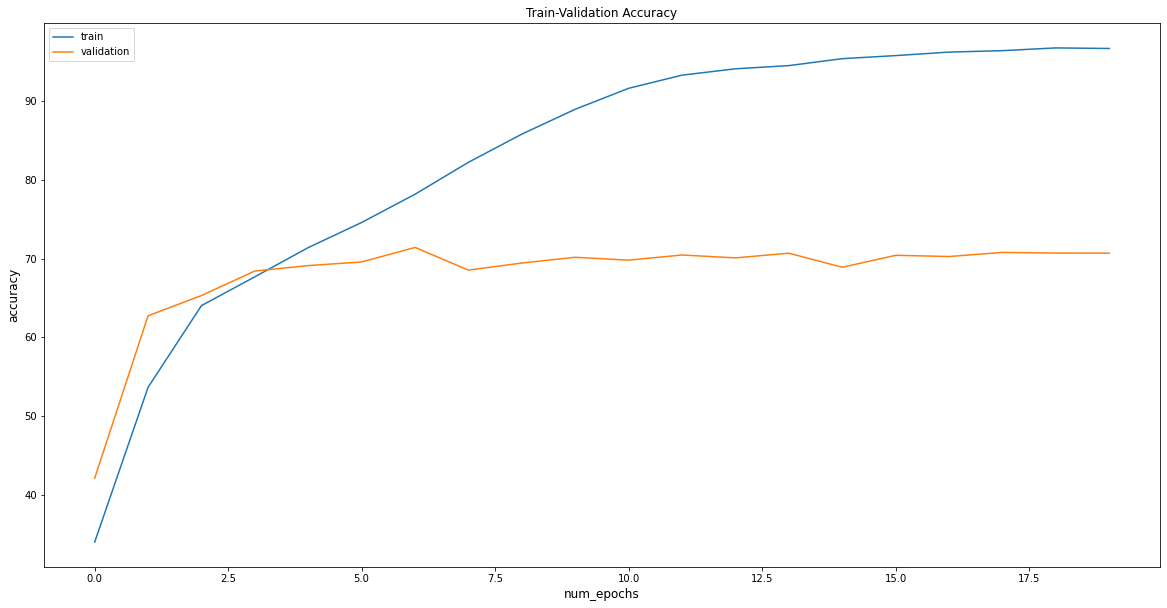

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

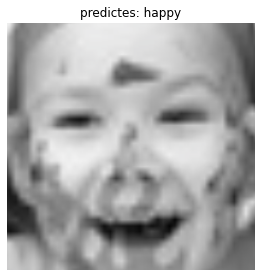

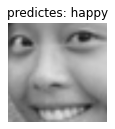

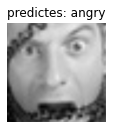

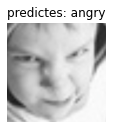

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()